In [270]:
!git clone https://github.com/tkyanaga/Auto_driving_sim

fatal: destination path 'Auto_driving_sim' already exists and is not an empty directory.


In [271]:
!ls Auto_driving_sim


driving_log.csv  IMG


In [272]:
!pip3 install imgaug

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa

import cv2
import pandas as pd
import ntpath

import random

In [274]:
datadir = 'Auto_driving_sim'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/Tyrone/Desktop/Driving Data/IMG/center_2019_03_25_17_58_31_595.jpg,/Users/Tyrone/Desktop/Driving Data/IMG/left_2019_03_25_17_58_31_595.jpg,/Users/Tyrone/Desktop/Driving Data/IMG/right_2019_03_25_17_58_31_595.jpg,0.0,0.0,0,0.000062
1,/Users/Tyrone/Desktop/Driving Data/IMG/center_2019_03_25_17_58_31_718.jpg,/Users/Tyrone/Desktop/Driving Data/IMG/left_2019_03_25_17_58_31_718.jpg,/Users/Tyrone/Desktop/Driving Data/IMG/right_2019_03_25_17_58_31_718.jpg,0.0,0.0,0,0.000062
2,/Users/Tyrone/Desktop/Driving Data/IMG/center_2019_03_25_17_58_31_839.jpg,/Users/Tyrone/Desktop/Driving Data/IMG/left_2019_03_25_17_58_31_839.jpg,/Users/Tyrone/Desktop/Driving Data/IMG/right_2019_03_25_17_58_31_839.jpg,0.0,0.0,0,0.000060
3,/Users/Tyrone/Desktop/Driving Data/IMG/center_2019_03_25_17_58_31_950.jpg,/Users/Tyrone/Desktop/Driving Data/IMG/left_2019_03_25_17_58_31_950.jpg,/Users/Tyrone/Desktop/Driving Data/IMG/right_2019_03_25_17_58_31_950.jpg,0.0,0.0,0,0.000061
4,/Users/Tyrone/Desktop/Driving Data/IMG/center_2019_03_25_17_58_32_058.jpg,/Users/Tyrone/Desktop/Driving Data/IMG/left_2019_03_25_17_58_32_058.jpg,/Users/Tyrone/Desktop/Driving Data/IMG/right_2019_03_25_17_58_32_058.jpg,0.0,0.0,0,0.000060


In [275]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,center_2019_03_25_17_58_31_595.jpg,left_2019_03_25_17_58_31_595.jpg,right_2019_03_25_17_58_31_595.jpg,0.0,0.0,0,0.000062
1,center_2019_03_25_17_58_31_718.jpg,left_2019_03_25_17_58_31_718.jpg,right_2019_03_25_17_58_31_718.jpg,0.0,0.0,0,0.000062
2,center_2019_03_25_17_58_31_839.jpg,left_2019_03_25_17_58_31_839.jpg,right_2019_03_25_17_58_31_839.jpg,0.0,0.0,0,0.000060
3,center_2019_03_25_17_58_31_950.jpg,left_2019_03_25_17_58_31_950.jpg,right_2019_03_25_17_58_31_950.jpg,0.0,0.0,0,0.000061
4,center_2019_03_25_17_58_32_058.jpg,left_2019_03_25_17_58_32_058.jpg,right_2019_03_25_17_58_32_058.jpg,0.0,0.0,0,0.000060


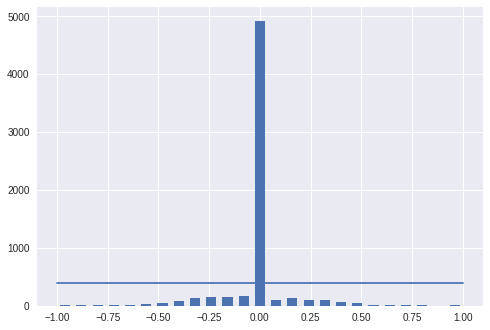

In [276]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5

plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

removed:  4516
remaining:  1845


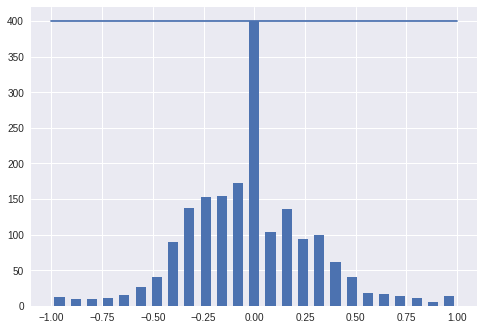

In [277]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [278]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip())) #.strip eliminates spaces
    #center image append
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
    
    image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2019_03_25_17_58_32_753.jpg
left        left_2019_03_25_17_58_32_753.jpg  
right       right_2019_03_25_17_58_32_753.jpg 
steering   -0.449076                          
throttle    1                                 
reverse     0                                 
speed       3.43416                           
Name: 10, dtype: object


In [279]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=5)
print('Training Samples: {}\nValid Samples:{}'.format(len(X_train), len(X_valid)))

Training Samples: 4428
Valid Samples:1107


Text(0.5, 1.0, 'Validation Set')

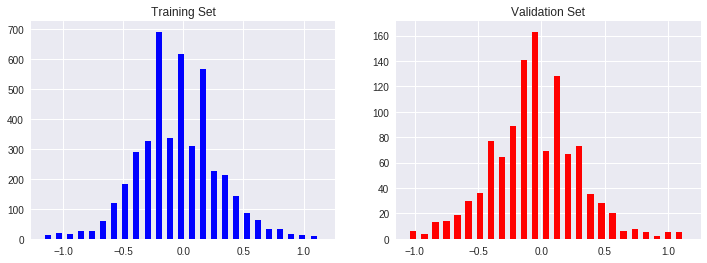

In [280]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training Set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation Set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed_image')

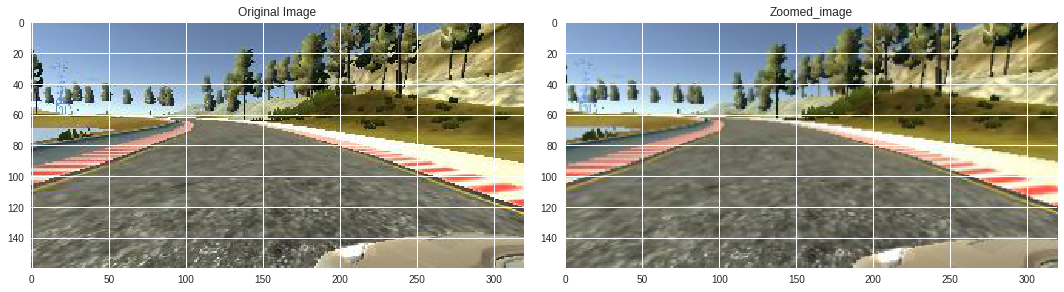

In [282]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed_image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-.1, .1), "y": (-.1, .1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned_image')

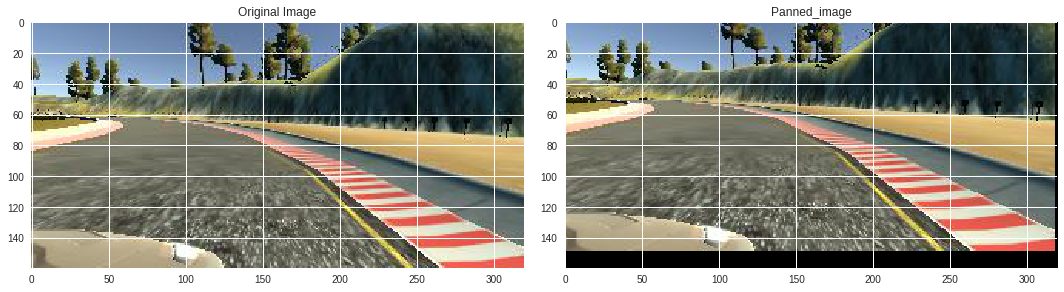

In [284]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned_image')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Altered image')

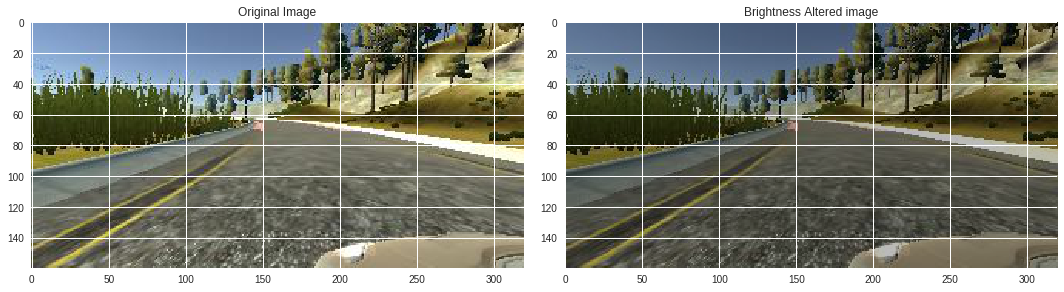

In [286]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightened_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightened_image)
axs[1].set_title('Brightness Altered image')

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1) #0 is vert, 1 is horizontal, -1 is both
  return image, -steering_angle #note: we flip the steering angle
def flip(i, j):
  return img_random_flip(i,j)

Text(0.5, 1.0, 'Flipped_image: -0.15')

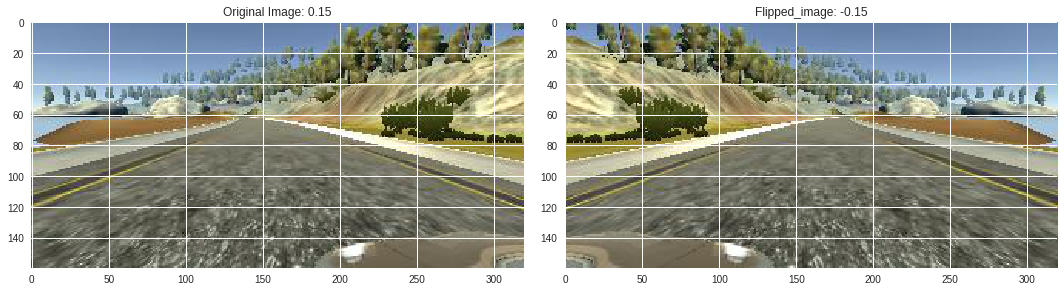

In [288]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_angle = flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image: ' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped_image: ' + str(flipped_angle))

In [0]:
def random_augment(image, st):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)  
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, st = flip(image, st)
  return image, st

In [290]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image: ' + str(random_steering))
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented_image: ' + str(steering))


Output hidden; open in https://colab.research.google.com to view.

In [0]:
def img_preprocess(img):
#   img = mpimg.imread(img)
  img = img[60:135 , :,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0) #img, kernel size, deviation of kernel
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img


Text(0.5, 1.0, 'Preprocessed')

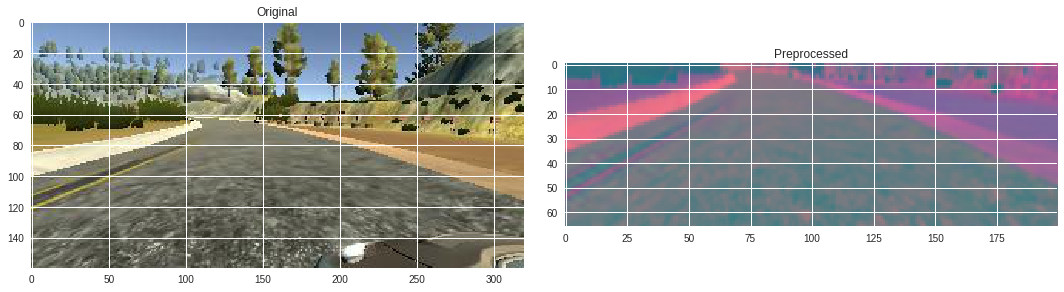

In [292]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original')

axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
      
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation')

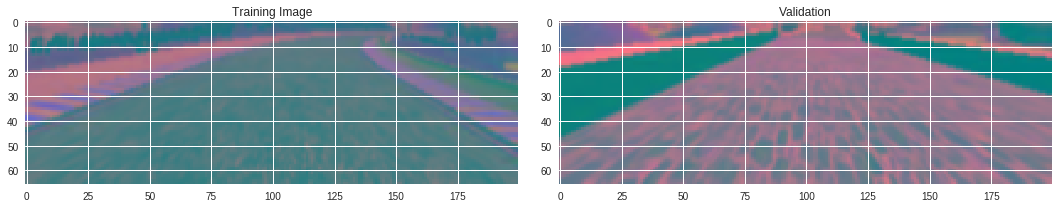

In [294]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_train, y_train, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation')

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='relu')) #subsample = stride length
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
#   model.add(Dropout(0.5)) #not needed with the additional augmented data
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model
  

In [296]:
model = nvidia_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               115300    
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), ac

In [297]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                              steps_per_epoch=300, 
                              epochs=10, 
                              validation_data=batch_generator(X_valid, y_valid, 100, 0), 
                              validation_steps = 200, 
                              verbose=1, 
                              shuffle=1)

Epoch 1/10
300/300 [==============================] - 166s 553ms/step - loss: 0.0800 - val_loss: 0.0547
Epoch 2/10
300/300 [==============================] - 160s 534ms/step - loss: 0.0624 - val_loss: 0.0522
Epoch 3/10
300/300 [==============================] - 161s 537ms/step - loss: 0.0577 - val_loss: 0.0535
Epoch 4/10
300/300 [==============================] - 161s 535ms/step - loss: 0.0553 - val_loss: 0.0488
Epoch 5/10
300/300 [==============================] - 161s 536ms/step - loss: 0.0541 - val_loss: 0.0477
Epoch 6/10
300/300 [==============================] - 161s 536ms/step - loss: 0.0535 - val_loss: 0.0495
Epoch 7/10
300/300 [==============================] - 161s 536ms/step - loss: 0.0535 - val_loss: 0.0491
Epoch 8/10
300/300 [==============================] - 160s 534ms/step - loss: 0.0528 - val_loss: 0.0483
Epoch 9/10
300/300 [==============================] - 160s 533ms/step - loss: 0.0522 - val_loss: 0.0476
Epoch 10/10
300/300 [==============================] - 160s 532m

Text(0.5, 0, 'Epoch')

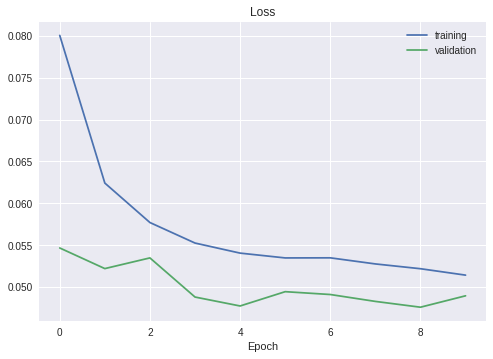

In [298]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')



In [0]:
model.save('model.h5')


In [0]:
from google.colab import files
files.download('model.h5')